In [1]:
from __future__ import annotations
from oop_functions.classifier_oop import *
from oop_functions.util_functions import *
from oop_functions.merge_dataset_functions import *
from oop_functions.analytics_oop import *

from xgboost import XGBClassifier

In [2]:
processed_data = pd.read_csv('./processed_dataset/recent_propagated_dataset.csv', index_col=0)

In [3]:
# drop non-cancer records without screen records
condition = (processed_data['was_screened'] == 1) | (processed_data['ovar_cancer'] == 1)
processed_data_filtered = processed_data[condition]

In [4]:
year = 1
label = f'cancer_in_next_{year}_years'
source_df = processed_data_filtered
source_df = resample_class(source_df, label, 0, 20000)

In [5]:

class ExperimentDataHelper1(ExperimentDataHelper):
    def _init_imputer(self) -> None:
        impute_const_dict = {
            'numcyst': 0,
            'ovcyst_morph': 0,
            'ovcyst_outline': 0,
            'ovcyst_solid': 0,
            'ovcyst_sum': 0,
            'ovcyst_vol': 0,
            'numcyst': 0,
            'tvu_result': 1,
            'numcystl': 0,
            'numcystr': 0,
            'ovcyst_diaml': 0,
            'ovcyst_diamr': 0,
            'ovcyst_morphl': 0,
            'ovcyst_morphr': 0,
            'ovcyst_outlinel': 0,
            'ovcyst_outliner': 0,
            'ovcyst_solidl': 0,
            'ovcyst_solidr': 0,
            'ovcyst_suml': 0,
            'ovcyst_sumr': 0,
            'ovcyst_voll': 0,
            'ovcyst_volr': 0,
            'visboth': 0,
            'viseith': 0,
            'visl': 0,
            'visr': 0
        }
        numeric_columns = select_numeric_columns(self.source_df)
        numeric_columns = list(set(numeric_columns) - set(impute_const_dict.keys()))
        self.imputer_util = ImputerUtil(impute_const_dict, impute_mean_cols=numeric_columns, impute_median_cols=[])

In [6]:
classifier = XGBClassifier(eval_metric= 'error', learning_rate= 0.1)
experiment_data_helper = ExperimentDataHelper1(source_df, label, ['cancer_'])


In [7]:
data_util_lambdas = experiment_data_helper.train_test_split_util.split_kfold(5)


In [8]:
data_util = data_util_lambdas[0]()


In [9]:
analytics_util = AnalyticsUtil(classifier, data_util).fit()

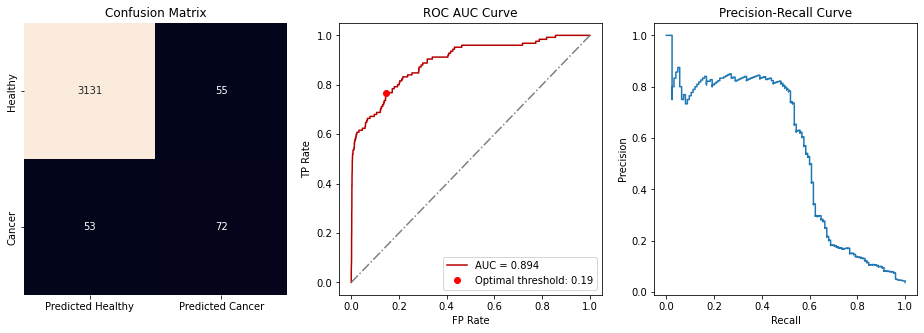

In [10]:
analytics_util.get_report_generation_util().display_graph()